In [17]:
# Import
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# from PGI_DC_example_Utils import plot_pseudoSection, getCylinderPoints

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

3.10.8 (main, Nov  4 2022, 13:48:29) [GCC 11.2.0]


In [18]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(50.)
ln_sigr = -np.log(10.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


/home/juan/anaconda3/envs/jresearch/lib/python3.10/site-packages/discretize/utils/code_utils.py:247: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


/home/juan/anaconda3/envs/jresearch/lib/python3.10/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/jresearch/lib/python3.10/site-packages/discretize/mixins/mpl_mod.py:302: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


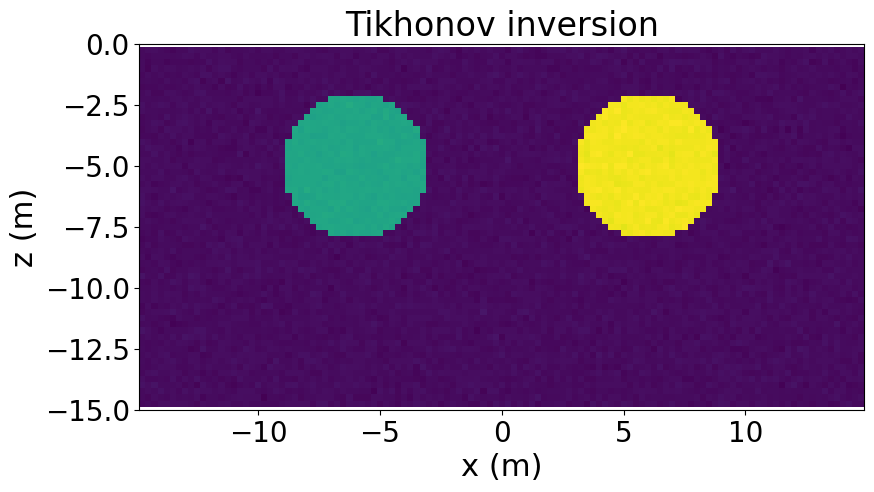

In [19]:
clim = [mtrue.min(), mtrue.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"viridis"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

In [26]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e-8)
)
mapping = expmap * mapactive
sim = dc.Simulation2DCellCentered(
    mesh,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)


std = 0.02
# survey.dpred(mtrue[actcore])
sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-4

m0 = -np.log(np.median((DCUtils.apparent_resistivity(survey)))) * np.ones(mapping.nP)

# expmap = Maps.ExpMap(mesh)
# mapactive = Maps.InjectActiveCells(
#     mesh=mesh,  indActive=actcore,
#     valInactive=np.unique(m0)
# )
# mapping = expmap * mapactive
# problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
# survey.unpair()
# problem.pair(survey)
# problem.Solver = PardisoSolver

/home/juan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:579: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/home/juan/Documents/git/simpeg/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:606: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


PardisoError: Analysis step error, reordering problem